In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import models, ops
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, f1_score

# Options: "covid_cxr" or "syntetic"
dataset_name = "syntetic"
epochs = 100
batch = 1024

In [2]:
root = '../..'
dataset_path = f"{root}/datasets/{dataset_name}_embeddings.npz"
predictions_path = f"{root}/datasets/{dataset_name}_predictions.npz"
siamese_save_path = f"{root}/models/{dataset_name}_siamese.keras"
classifier_path = f"{root}/models/{dataset_name}_classifier.keras"

## MODELS
def distance(vects):
    """
    Computes the cosine distance between pairs of vectors.
    """
    x, y = vects[:,0], vects[:,1]
    x = ops.normalize(x, axis=1)
    y = ops.normalize(y, axis=1)
    return ops.sum(x * y, axis=1)

@keras.saving.register_keras_serializable()
def contrastive_Sig_loss(y_true, y_pred):
    z = (0.5 - y_true) * 2  # z = 1 per D+, z = -1 per D-
    dist = distance(y_pred)

    similarity = ops.negative(1.0 * dist) + 0.0
    denomiator = 1 + ops.exp(z * similarity)
    batch_loss = ops.log(1 / denomiator)
    return ops.negative(ops.mean(batch_loss))

classifier = models.load_model(classifier_path)
best_siamese = models.load_model(siamese_save_path)
correction = best_siamese.get_layer('correction')

In [3]:
## DATASET
dataset = np.load(dataset_path, allow_pickle=True)

x_train = dataset['x_train']
y_train = dataset['y_train']
x_val = dataset['x_val']
y_val = dataset['y_val']
x_test = dataset['x_test']
y_test = dataset['y_test']

## DATASET PREDICTIONS
predictions = np.load(predictions_path, allow_pickle=True)
y_train_pred = predictions['y_train_pred']
y_val_pred = predictions['y_val_pred']
y_test_pred = predictions['y_test_pred']

## DATASET MODIFICATION
x_train_modified = correction(x_train)
x_val_modified = correction(x_val)
x_test_modified = correction(x_test)

## BALANCE CLASSES
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)
total_classes = len(train_counts)
class_weights = {i: len(y_train) / (total_classes * count) for i, count in enumerate(train_counts)}


In [4]:
## RE-TRAINING THE CLASSIFIER
classifier = models.load_model(classifier_path)
classifier_new = keras.models.clone_model(classifier)
classifier_new.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [5]:
history = classifier_new.fit(
    x_train_modified, y_train,
    validation_data=(x_val_modified, y_val),
    epochs=epochs,
    batch_size=batch,
    class_weight=class_weights,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=epochs, restore_best_weights=True)
    ]
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6997 - loss: 1.5429 - val_accuracy: 0.4880 - val_loss: 8.2525
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7166 - loss: 2.2954 - val_accuracy: 0.5160 - val_loss: 2.8575
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7874 - loss: 2.7393 - val_accuracy: 0.5867 - val_loss: 1.4692
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7934 - loss: 2.6307 - val_accuracy: 0.4880 - val_loss: 8.2525
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8054 - loss: 2.1607 - val_accuracy: 0.4880 - val_loss: 8.2525
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7691 - loss: 1.6381 - val_accuracy: 0.4880 - val_loss: 8.2525
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7460 - loss: 0.9296 - val_accuracy: 0.5120 - val_loss: 2.8800
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7591 - loss: 1.1051 - val_accuracy: 0.4880 - val_loss: 2.7048


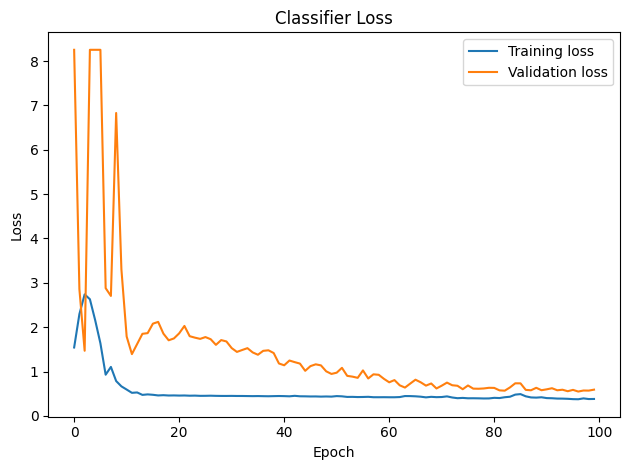

In [6]:
plt.figure(figsize=None)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title(f'Classifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step


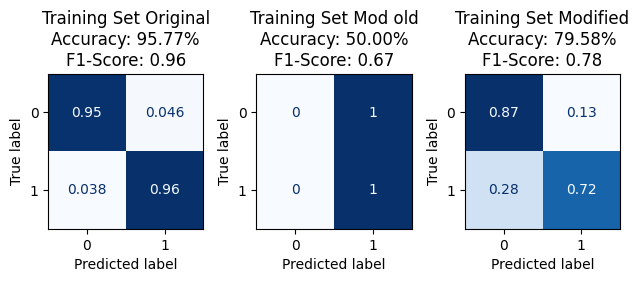

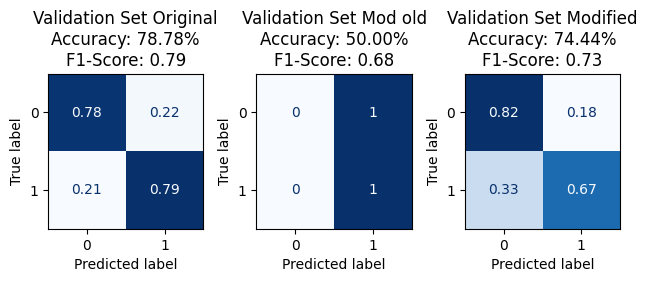

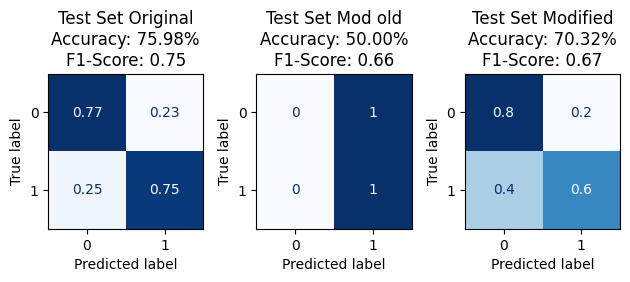

In [7]:
## EVALUATION NEW CLASSIFIER VS OLD CLASSIFIER
y_train_pred_new = classifier_new.predict(x_train_modified)
y_val_pred_new = classifier_new.predict(x_val_modified)
y_test_pred_new = classifier_new.predict(x_test_modified)

y_train_pred_old = classifier.predict(x_train_modified)
y_val_pred_old = classifier.predict(x_val_modified)
y_test_pred_old = classifier.predict(x_test_modified)

data_to_evaluate = [
    ("Training Set", y_train, y_train_pred, ops.argmax(y_train_pred_old, axis=1), ops.argmax(y_train_pred_new, axis=1)),
    ("Validation Set", y_val, y_val_pred, ops.argmax(y_val_pred_old, axis=1), ops.argmax(y_val_pred_new, axis=1)),
    ("Test Set", y_test, y_test_pred, ops.argmax(y_test_pred_old, axis=1), ops.argmax(y_test_pred_new, axis=1))
]

for title, y_true, y_pred, y_pred_old, y_pred_new in data_to_evaluate:
    list_data = [("Original", y_pred), ("Mod old", y_pred_old), ("Modified", y_pred_new)]
    _, axes = plt.subplots(1, len(list_data), figsize=None)
    for i, (what_data, yy) in enumerate(list_data):
        ConfusionMatrixDisplay.from_predictions(
            y_true, yy,
            normalize='true',
            display_labels=[i for i in range(total_classes)],
            cmap=plt.cm.Blues,
            colorbar=False,
            ax=axes[i]
        )
        axes[i].set_title(f"{title} {what_data}\n"
                            + f"Accuracy: {balanced_accuracy_score(y_true, yy):.2%}\n"
                            + f"F1-Score: {f1_score(y_true, yy):.2f}")
    plt.tight_layout()
    plt.show()
